In [1]:
import random

import leverage_effect as leveff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

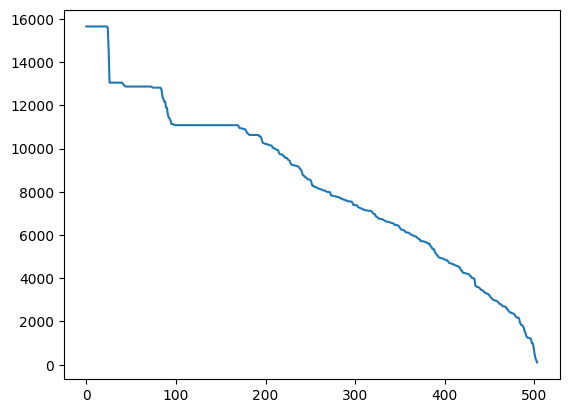

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


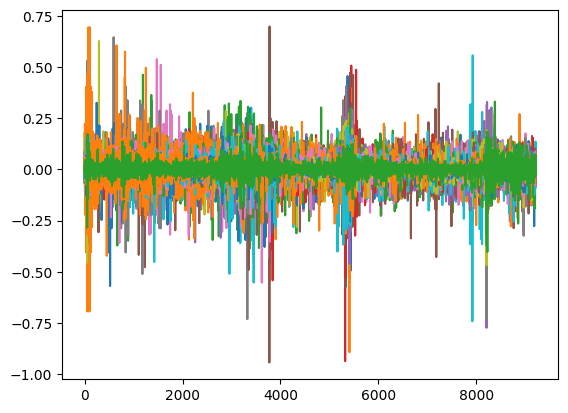

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

tau : 50.26699108774909
std tau 355.0436916486315
exp r : 0.6888065666770128
exp r std = 0.15095285987414653
rate = -0.6751522558367845
rate std = 0.18478433585766973
pow r = 0.7477986784747183
pow r std = 0.15084486290810695


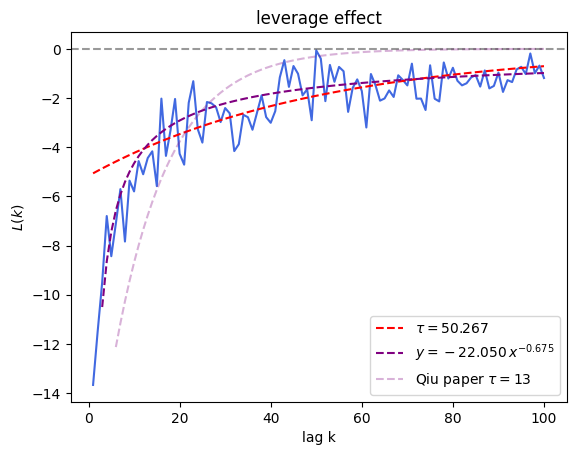

In [7]:
stat = leveff.leverage_effect_stats(log_returns=np_ret, max_lag=100)
lev_eff = stat["lev_eff"]
y = np.mean(lev_eff, axis=1)
x = np.arange(1, y.size + 1)

exp_c, exp_tau, exp_r, pow_c, pow_rate, pow_r = (
    stat["exp_c"],
    stat["exp_tau"],
    stat["exp_r"],
    stat["pow_const"],
    stat["pow_rate"],
    stat["pow_r"],
)
x_lin = np.linspace(np.min(x), np.max(x), num=100)
y_lin = -exp_c * np.exp(-x_lin / exp_tau)
y_lin_qiu = -20 * np.exp(-x_lin / 12)
y_pow = -np.exp(pow_c) * np.power(x_lin, pow_rate)

std_tau = stat["exp_tau_std"]
std_rate = stat["pow_rate_std"]
std_r_exp = stat["exp_r_std"]
std_r_pow = stat["pow_r_std"]

plt.gca().set(**leveff.lev_eff_axes_setting)
plt.plot(x, y, **leveff.lev_eff_plot_setting)
plt.plot(x_lin, y_lin, label="$\\tau = 50.267$", color="red", linestyle="--", alpha=1)
plt.plot(
    x_lin[2:],
    y_pow[2:],
    label=f"$y = -{np.exp(pow_c):.3f} \\,  x^{{{pow_rate:.3f}}}$",
    color="purple",
    linestyle="--",
    alpha=1,
)
plt.plot(
    x_lin[5:],
    y_lin_qiu[5:],
    label="Qiu paper $\\tau = 13$",
    color="purple",
    linestyle="--",
    alpha=0.3,
)
plt.gca().axhline(y=0, linestyle="--", c="black", alpha=0.4)
print(f"tau : {exp_tau}")
print(f"std tau {std_tau}")
print(f"exp r : {exp_r}")
print(f"exp r std = {std_r_exp}")
print(f"rate = {pow_rate}")
print(f"rate std = {std_rate}")
print(f"pow r = {pow_r}")
print(f"pow r std = {std_r_pow}")
plt.yscale("linear")
plt.xscale("linear")
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/le.png")
plt.show()